In [1]:
# Install the relevant packages.

! pip install numpy==1.24.4 matplotlib==3.8.4 torch==2.0.1+cu118 torchvision==0.15.2+cu118 scikit-learn==1.4.2 -q --extra-index-url https://download.pytorch.org/whl/cu126

In [2]:
# Import the relevant libraries


import matplotlib.pyplot as plt

import numpy as np

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torchvision

from sklearn.model_selection import train_test_split


import cudaq
from cudaq import spin

torch.manual_seed(22)
cudaq.set_random_seed(44)

In [3]:
# Set CUDAQ and PyTorch to run on either CPU or GPU.

#device = torch.device('cpu')
#cudaq.set_target("qpp-cpu")

cudaq.set_target("tensornet")
device = torch.device("cuda:0")

In [4]:
def prepare_data(target_digits, sample_count, test_size):
    """Load and prepare the MNIST dataset to be used

    Args:
        target_digits (list): digits to perform classification of
        sample_count (int): total number of images to be used
        test_size (float): percentage of sample_count to be used as test set, the remainder is the training set

    Returns:
        dataset in train, test format with targets

    """

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.1307), (0.3081))])

    dataset = datasets.MNIST("./data",
                             train=True,
                             download=True,
                             transform=transform)

    # Filter out the required labels.
    idx = (dataset.targets == target_digits[0]) | (dataset.targets
                                                   == target_digits[1])
    dataset.data = dataset.data[idx]
    dataset.targets = dataset.targets[idx]

    # Select a subset based on number of datapoints specified by sample_count.
    subset_indices = torch.randperm(dataset.data.size(0))[:sample_count]

    x = dataset.data[subset_indices].float().unsqueeze(1).to(device)

    y = dataset.targets[subset_indices].to(device).float().to(device)

    # Relabel the targets as a 0 or a 1.
    y = torch.where(y == min(target_digits), 0.0, 1.0)

    x_train, x_test, y_train, y_test = train_test_split(x,
                                                        y,
                                                        test_size=test_size /
                                                        100,
                                                        shuffle=True,
                                                        random_state=42)

    return x_train, x_test, y_train, y_test

In [5]:
# Classical parameters.

sample_count = 1000  # Total number of images to use.
target_digits = [5, 6]  # Hand written digits to classify.
test_size = 30  # Percentage of dataset to be used for testing.
classification_threshold = 0.5  # Classification boundary used to measure accuracy.
epochs = 2  # Number of epochs to train for.

# Quantum parmeters.

qubit_count = 1  # Number of qubits to use.
hamiltonian = spin.z(0)  # Measurement operator.
shift = torch.tensor(torch.pi / 2)  # Magnitude of parameter shift.

In [6]:
x_train, x_test, y_train, y_test = prepare_data(target_digits, sample_count,test_size)

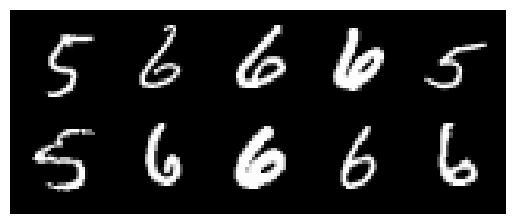

In [7]:
# Plot some images from the training set to visualise.
if device != 'cpu':
    sample_to_plot = x_train[:10].to(torch.device('cpu'))
else:
    sample_to_plot = x_train[:10]

grid_img = torchvision.utils.make_grid(sample_to_plot,
                                       nrow=5,
                                       padding=3,
                                       normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [8]:
class QuantumFunction(Function):
    """Allows the quantum circuit to input data, output expectation values
    and calculate gradients of variational parameters via finite difference"""

    def __init__(self, qubit_count: int, hamiltonian: cudaq.SpinOperator):
        """Define the quantum circuit in CUDA Quantum"""

        @cudaq.kernel
        def kernel(qubit_count: int, thetas: np.ndarray):

            qubits = cudaq.qvector(qubit_count)

            ry(thetas[0], qubits[0])
            rx(thetas[1], qubits[0])

        self.kernel = kernel
        self.qubit_count = qubit_count
        self.hamiltonian = hamiltonian

    def run(self, theta_vals: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""

        #If running on GPU, thetas is a torch.tensor that will live on GPU memory. The observe function calls a .tolist() method on icputs which moves thetas from GPU to CPU.

        qubit_count = [self.qubit_count for _ in range(theta_vals.shape[0])]

        results = cudaq.observe(self.kernel, self.hamiltonian, qubit_count,
                                theta_vals)

        exp_vals = [results[i].expectation() for i in range(len(results))]
        exp_vals = torch.Tensor(exp_vals).to(device)

        return exp_vals

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:

        # Save shift and quantum_circuit in context to use in backward.
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate expectation value.
        exp_vals = ctx.quantum_circuit.run(thetas).reshape(-1, 1)

        ctx.save_for_backward(thetas, exp_vals)

        return exp_vals

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference"""

        thetas, _ = ctx.saved_tensors

        gradients = torch.zeros(thetas.shape, device=device)

        for i in range(thetas.shape[1]):

            thetas_plus = thetas.clone()
            thetas_plus[:, i] += ctx.shift
            exp_vals_plus = ctx.quantum_circuit.run(thetas_plus)

            thetas_minus = thetas.clone()
            thetas_minus[:, i] -= ctx.shift
            exp_vals_minus = ctx.quantum_circuit.run(thetas_minus)

            gradients[:, i] = (exp_vals_plus - exp_vals_minus) / (2 * ctx.shift)

        gradients = torch.mul(grad_output, gradients)

        return gradients, None, None

In [9]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit into a quantum layer adhering PyTorch convention"""

    def __init__(self, qubit_count: int, hamiltonian, shift: torch.tensor):
        super(QuantumLayer, self).__init__()

        self.quantum_circuit = QuantumFunction(qubit_count, hamiltonian)
        self.shift = shift

    def forward(self, input):

        result = QuantumFunction.apply(input, self.quantum_circuit, self.shift)

        return result

In [10]:
class Hybrid_QNN(nn.Module):
    """Structure of the hybrid neural network with classical fully connected layers and quantum layers"""

    def __init__(self):
        super(Hybrid_QNN, self).__init__()

        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.25)

        # The 2 outputs from PyTorch fc5 layer feed into the 2 variational gates in the quantum circuit.
        self.quantum = QuantumLayer(qubit_count, hamiltonian, shift)

    def forward(self, x):

        x = x.view(-1, 28 * 28)  # Turns images into vectors.

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)

        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)

        # Quantum circuit outputs an expectation value which is fed into the sigmoid activation function to perform classification.
        x = torch.sigmoid(self.quantum(x))

        return x.view(-1)

In [11]:
def accuracy_score(y, y_hat, classification_threshold=0.5):
    # Compute accuracy directly on the GPU
    correct = (y == (y_hat >= classification_threshold)).float().sum()
    accuracy = correct / y.size(0)
    return accuracy

In [12]:
import time
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim
import torch


class HybridTrainer:
    def __init__(self, model, optimizer, loss_function, writer, device):
        """
        Initializes the trainer class.

        Args:
            model (torch.nn.Module): The PyTorch model to train and evaluate.
            optimizer (torch.optim.Optimizer): The optimizer for training.
            loss_function (torch.nn.Module): The loss function.
            writer (SummaryWriter): TensorBoard SummaryWriter instance.
            device (torch.device): Device to run the computations on (e.g., 'cpu' or 'cuda').
        """
        self.model = model
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.writer = writer
        self.device = device

        self.training_cost = []
        self.testing_cost = []
        self.training_accuracy = []
        self.testing_accuracy = []

    def train(self, x_train, y_train, epoch):
        """
        Runs one epoch of training and logs metrics.

        Args:
            x_train (torch.Tensor): Training data.
            y_train (torch.Tensor): Training labels.
            epoch (int): Current epoch index.
        """
        train_start_time = time.time()

        self.model.train()
        self.optimizer.zero_grad()

        # Forward pass
        y_hat_train = self.model(x_train).to(self.device)
        train_cost = self.loss_function(y_hat_train, y_train).to(self.device)

        # Backward pass
        train_cost.backward()
        self.optimizer.step()

        # Compute accuracy
        accuracy = accuracy_score(y_train, y_hat_train)
        self.training_accuracy.append(accuracy)
        self.training_cost.append(train_cost.item())

        # Log training time
        train_elapsed_time = time.time() - train_start_time
        self.writer.add_scalar("Time(s) per epoch/Train", train_elapsed_time, epoch + 1)

        # Log training metrics to TensorBoard
        self.writer.add_scalar("Loss/Train", train_cost.item(), epoch + 1)
        self.writer.add_scalar("Accuracy/Train", accuracy, epoch + 1)
    def test(self, x_test, y_test, epoch):
        """
        Runs one evaluation step and logs metrics.

        Args:
            x_test (torch.Tensor): Testing data.
            y_test (torch.Tensor): Testing labels.
            epoch (int): Current epoch index.
        """
        eval_start_time = time.time()

        self.model.eval()
        with torch.no_grad():
            # Forward pass
            y_hat_test = self.model(x_test).to(self.device)
            test_cost = self.loss_function(y_hat_test, y_test).to(self.device)

            # Compute accuracy
            accuracy = accuracy_score(y_test, y_hat_test)
            self.testing_accuracy.append(accuracy)
            self.testing_cost.append(test_cost.item())

            # Log evaluation time
            eval_elapsed_time = time.time() - eval_start_time
            self.writer.add_scalar("Time(s) per epoch/Eval", eval_elapsed_time, epoch + 1)

            # Log testing metrics to TensorBoard
            self.writer.add_scalar("Loss/Test", test_cost.item(), epoch + 1)
            self.writer.add_scalar("Accuracy/Test", accuracy, epoch + 1)

In [13]:
import datetime

# Generate a unique log directory with timestamp
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"./runs/hybrid_qnn_training_{current_time}"

writer = SummaryWriter(log_dir=log_dir)

# Initialize the trainer with your model, optimizer, loss function, etc.
hybrid_model = Hybrid_QNN().to(device)
trainer = HybridTrainer(
    model=hybrid_model,
    optimizer=optim.Adadelta(hybrid_model.parameters(), lr=0.001, weight_decay=0.8),
    loss_function=nn.BCELoss().to(device),
    writer=writer,
    device=device
)

In [14]:
for epoch in range(epochs):
    # Call the train and test methods for each epoch
    trainer.train(x_train, y_train, epoch)
    print(f"Epoch {epoch + 1}/{epochs} Training done.")
    trainer.test(x_test, y_test, epoch)
    print(f"Testing done.")

# Close the TensorBoard writer
writer.close()

Epoch 1/2 Training done.
Testing done.
Epoch 2/2 Training done.
Testing done.


In [15]:
'''from torch.utils.tensorboard import SummaryWriter

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir="./runs/hybrid_qnn_training")

# Existing code
hybrid_model = Hybrid_QNN().to(device)

optimizer = optim.Adadelta(hybrid_model.parameters(),
                           lr=0.001,
                           weight_decay=0.8)

loss_function = nn.BCELoss().to(device)

training_cost = []
testing_cost = []
training_accuracy = []
testing_accuracy = []

hybrid_model.train()


import time
for epoch in range(epochs):

    train_start_time = time.time()

    optimizer.zero_grad()

    y_hat_train = hybrid_model(x_train).to(device)

    train_cost = loss_function(y_hat_train, y_train).to(device)

    train_cost.backward()

    optimizer.step()

    training_accuracy.append(accuracy_score(y_train, y_hat_train))
    training_cost.append(train_cost.item())

    train_elapsed_time = time.time() - train_start_time
    writer.add_scalar("Time/Train", train_elapsed_time, epoch + 1)

    writer.add_scalar("Loss/Train", train_cost.item(), epoch + 1)
    writer.add_scalar("Accuracy/Train", training_accuracy[-1], epoch + 1)

    eval_start_time = time.time()

    hybrid_model.eval()
    with torch.no_grad():

        y_hat_test = hybrid_model(x_test).to(device)

        test_cost = loss_function(y_hat_test, y_test).to(device)

        testing_accuracy.append(accuracy_score(y_test, y_hat_test))
        testing_cost.append(test_cost.item())


        # Log testing metrics to TensorBoard
        writer.add_scalar("Loss/Test", test_cost.item(), epoch + 1)
        writer.add_scalar("Accuracy/Test", testing_accuracy[-1], epoch + 1)

# Close TensorBoard writer
writer.close()'''

'from torch.utils.tensorboard import SummaryWriter\n\n# Initialize TensorBoard writer\nwriter = SummaryWriter(log_dir="./runs/hybrid_qnn_training")\n\n# Existing code\nhybrid_model = Hybrid_QNN().to(device)\n\noptimizer = optim.Adadelta(hybrid_model.parameters(),\n                           lr=0.001,\n                           weight_decay=0.8)\n\nloss_function = nn.BCELoss().to(device)\n\ntraining_cost = []\ntesting_cost = []\ntraining_accuracy = []\ntesting_accuracy = []\n\nhybrid_model.train()\n\n\nimport time\nfor epoch in range(epochs):\n\n    train_start_time = time.time()\n\n    optimizer.zero_grad()\n\n    y_hat_train = hybrid_model(x_train).to(device)\n\n    train_cost = loss_function(y_hat_train, y_train).to(device)\n\n    train_cost.backward()\n\n    optimizer.step()\n\n    training_accuracy.append(accuracy_score(y_train, y_hat_train))\n    training_cost.append(train_cost.item())\n\n    train_elapsed_time = time.time() - train_start_time\n    writer.add_scalar("Time/Train",

NameError: name 'training_cost' is not defined

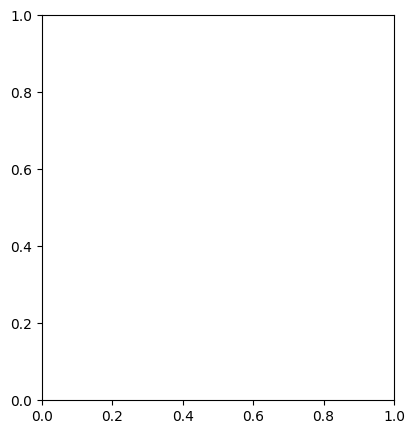

In [16]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_cost, label='Train')
plt.plot(testing_cost, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()

plt.subplot(1, 2, 2)
training_accuracy = np.array(torch.tensor(training_accuracy).cpu())
testing_accuracy = np.array(torch.tensor(testing_accuracy).cpu())
plt.plot(training_accuracy, label='Train')
plt.plot(testing_accuracy, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()